# Init Environment

## Note

In [ ]:
# note of the module installations
# install python with pyenv (ref: https://github.com/lewagon/data-setup/blob/e5a239926f304d452704718136b6e2f017c7303d/macOS.md#installing-python-with-pyenv)
# setup virtual environment with pyenv (ref:https://github.com/lewagon/data-setup/blob/e5a239926f304d452704718136b6e2f017c7303d/macOS.md#installing-python-with-pyenv
# error: 'Failed to activate virtualenv' (ref:https://github.com/pyenv/pyenv-virtualenv/issues/387)
# pip install fasttext (0.9.2) (after installing the dependencies: numpy, scipy, pybind11, setuptools, wheel)

# install Jupyter notebook and nbextensions (ref: https://github.com/lewagon/data-setup/blob/e5a239926f304d452704718136b6e2f017c7303d/macOS.md#jupyter-notebook-extensions)
#   pip install jupyter_contrib_nbextensions
#   pip install --upgrade notebook==6.4.12 (ref:https://stackoverflow.com/questions/49647705/jupyter-nbextensions-does-not-appear)
#   pip install traitlets==5.9.0

## Import modules

In [ ]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from tqdm import tqdm
import concurrent.futures

import sys
sys.path.append('../')

from src.config import *
from src.helper_visualization import *
from src.helper_text import *
from src.helper_langID import *
from src.helper_translation import *
from src.helper_pred import *

# Combine Data Source

In [ ]:
import glob

# Get a list of file paths that match the pattern
files = glob.glob(f'{DATA_FOLDER_PATH_RAW}/data_202*.xlsx')
# Create an empty list to store DataFrames
dfs = []

# Loop through each file and read it into a DataFrame
for file in files:
    df = pd.read_excel(file, index_col=None)
    dfs.append(df)

# Concatenate the DataFrames into one
df_combined = pd.concat(dfs, ignore_index=True)
df_combined.info()

In [ ]:
#check for null values
df_combined.isnull().sum().sort_values(ascending = False)

In [ ]:
# columns which have large number of null values will be dropped 
columns_to_drop = [
    'Escalated To Engineering', 
    'Bug Type', 
    'Status Reason', 
    'Escalated to L2',
    'Category',
    'Completion Code'
]
try: 
    df_combined.drop(columns_to_drop, axis=1, inplace = True)
    df_combined.dropna(subset=['Request ID'], inplace=True)
    df_combined.dropna(subset=['Product Name'], inplace=True)
    df_combined.dropna(subset=['Title'], inplace=True)
except:
    pass
# surprisingly, there are over 100k duplications
df_combined.drop_duplicates(subset=['Title', 'Product Name'], keep='first', inplace=True)

In [ ]:
df_combined.isnull().sum().sort_values(ascending = False)

In [ ]:
# Specify the file name and path
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_combined.xlsx'

# Export the DataFrame to Excel
df_combined.to_excel(excel_file, index=False)  # Set index to False if you don't want to export the DataFrame index

# Load Data for Pre-processing

In [ ]:
if 'df_combined' not in locals():
    data_url = f'{DATA_FOLDER_PATH_PROCESSED}/data_combined.xlsx'
    df_combined = pd.read_excel(data_url, index_col=None)
print(df_combined.info())

# Clean-up the Title Column

## Quick Clean-up

In [ ]:
df_processed = df_combined.copy()

# Delete unnecessary columns, add needed columns
df_processed.drop(columns=[
    'Created Time', 
    'Customer Company', 'Customer Country', 
    'Priority', 'Urgency', 'Impact', 
    'Service Definition', 'Service Desk Group', 'Status',
    'Closed Time', 
    'Response Time (Min)', 'Resolution Time (Min)', 
    'Contracts Reference', 'Creation Source'
    ], inplace=True)

# Add new columns
df_processed['Length'] = 0
df_processed['Language']=pd.NA
df_processed['Title_Processed']=pd.NA
df_processed['Title_Translated']=pd.NA
df_processed['Title_Enhanced']=pd.NA
df_processed['Tags']=pd.NA


# Run quick clean up on the 'Title' column and save the result to the 'Title_Processed' column

# Set the number of rows to process
num = df_processed['Title'].notnull().sum()

# Initialize a progress bar with the total number of rows
progress_bar = tqdm(total=num, desc="Processing Rows", unit=" row")

# Function to process a single row and update the 'Processed_Title' column
def process_row(index):
    # processed_title = preprocess_step_1(df_combined.at[index, 'Title'])
    processed_title = quick_clean_up(df_processed.at[index, 'Title'])
    df_processed.at[index, 'Title_Processed'] = processed_title
    df_processed.at[index, 'Length'] = len(processed_title)
    progress_bar.update(1)

# Define the number of parallel workers (adjust this based on your CPU cores)
num_workers = 8

# Create a ThreadPoolExecutor with the specified number of workers
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Use the executor to process rows in parallel
    executor.map(process_row, df_processed.index)

# Close the progress bar
progress_bar.close()

# Delete records with missing values in 'Title_Processed' columns
df_processed.dropna(subset=['Title_Processed'], inplace=True)

# Remove duplicates based on 'Title_Processed' and 'ProductName' columns
df_processed.drop_duplicates(subset=['Title_Processed', 'Product Name'], keep='first', inplace=True)

print(df_processed.info())
hist_by_labels(df_processed, 'Length', log=False)

## Language Detection

In [ ]:
# Run language detection on the 'Title_Processed' column and save the result to the 'Language' column
# This is the step required to run bulk language translation using Google Translate API for performance reason
# The language detection is done using FastText library since FastText is better than the langdetect library and other options.
# ref: https://medium.com/besedo-engineering/language-identification-for-very-short-texts-a-review-c9f2756773ad
# FastText has difficulty detecting CJK languages mixed with English, so we will use udf-8 encoding to detect CJK languages directly.

# Set the number of rows to process
num = df_processed['Title_Processed'].notnull().sum()

# df['Title_Translated'] = df['Title_Processed']
# Initialize a progress bar with the total number of rows
progress_bar = tqdm(total=num, desc="Processing Rows", unit=" row")

# Function to process a single row and update the 'Processed_Title' column
def process_row(index):
    df_processed.at[index, 'Language'] = detect_language_fasttext(df_processed.at[index, 'Title_Processed'])
    progress_bar.update(1)

# Define the number of parallel workers (adjust this based on your CPU cores)
num_workers = 8

# Create a ThreadPoolExecutor with the specified number of workers
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Use the executor to process rows in parallel
    executor.map(process_row, df_processed.index)

# Close the progress bar
progress_bar.close()

hist_by_labels(df_processed, "Language", log=True, horizontal=True, left=10.5)

print(f"Language detected with low confidence: \033[94m{df_processed['Language'].value_counts(normalize=True)['unknown'] * 100:.3f}%\033[0m.")
df_processed.head(20)

In [ ]:
# Save the DataFrame to Excel for future steps without having to run the previous steps again

# Specify the file name and path
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_processed.xlsx'

# Export the DataFrame to Excel
df_processed.to_excel(excel_file, index=False)  # Set index to False if you don't want to export the DataFrame index

## Translation of Non-English

In [ ]:
# load the processed data df_processed if not loaded yet
if 'df_processed' not in locals():
    excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_processed.xlsx'
    df_processed = pd.read_excel(excel_file)

df_translated = df_processed.copy()
df_translated['Title_Translated'] = df_translated['Title_Processed']

# Keep the top 10 languages and drop the rest and the unknown. 
# why? There are high chances the detected language were not correct due to wrong spelling, etc.
hist_by_labels(df_processed, "Language", log=True, horizontal=True, left=10.5)

language_counts = df_translated['Language'].value_counts()
cutoff = 90
language_others = language_counts.index[language_counts < cutoff]

mask_others = df_translated['Language'].isin(language_others)
df_translated.loc[mask_others,'Language']='unknown'

# Drop rows where 'Language' is equal to 'unknown'
df_detection_unknown = df_translated[df_translated['Language'] == 'unknown']
df_translated = df_translated[df_translated['Language'] != 'unknown']

print(f"Language detected with low confidence: \033[94m{df_detection_unknown.shape[0]}\033[0m.")
print(df_translated.info())

In [ ]:
# Translate the 'Title_Processed' column and save the result to the 'Title_Translated' column
# language by language to avoid Google Translate API quota limit
# skip English obviously
# the length limit is 1250 characters due to Google Translate API limit for CJK languages

grouped = df_translated.groupby("Language")

# Initialize tqdm to display progress bar
pbar = tqdm(total=len(grouped), desc=f"Translating")

# Create an empty list to store the processed groups
processed_groups = []

# Iterate through sub DataFrames
for lang, group in grouped:
    pbar.set_description(f"Processing [\033[94m{lang}/{len(group)}\033[0m]")

    translated_titles = translate_array(
        group["Title_Translated"].tolist(),
        src_lang=lang,
        tar_lang='en',
        length_limit=1250)
    group["Title_Translated"] = translated_titles  # Update "Title_Translated" column in the group
    
    processed_groups.append(group)
    pbar.update(1)  # Update the progress bar

# Close the progress bar
pbar.close()

# Concatenate the groups back into a single DataFrame
df_translated = pd.concat(processed_groups, ignore_index=True)

In [ ]:
# Delete records with missing values in 'Title_Translated' columns
# there should be no missing values in 'Title_Translated' columns but just in case
df_translated.dropna(subset=['Title_Translated'], inplace=True)

# remove the confusion between Petrel and Petrel RE
df_translated['Title_Translated'] = df_translated['Title_Translated'].str.replace('petrel re', 'PetrelRE', case=False)

# Remove duplicates based on 'Title_Translated' and 'Product Name' columns
df_translated.drop_duplicates(subset=['Title_Translated', 'Product Name'], keep='first', inplace=True)

print(df_translated.info())
df_translated.head(20)

In [ ]:
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_translated.xlsx'
df_translated.to_excel(excel_file, index=False)  # Set index to False if you don't want to export the DataFrame index

excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_langID_unknown.xlsx'
df_detection_unknown.to_excel(excel_file, index=False) 

## Enhance the Title

In [33]:
if 'df_translated' not in locals():
    excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_translated.xlsx'
    df_translated = pd.read_excel(excel_file)


# Set the number of rows to process
num = df_cleaned['Title_Translated'].notnull().sum()
df_cleaned['Title_Enhanced'] = ""
# Initialize a progress bar with the total number of rows
progress_bar = tqdm(total=num, desc="Processing Rows", unit=" row")

# Function to process a single row and update the 'Processed_Title' column
def process_row(index):
    df_cleaned.at[index, 'Title_Enhanced'] = enhance_title(df_cleaned.at[index, 'Title_Translated'])
    progress_bar.update(1)

# Define the number of parallel workers (adjust this based on your CPU cores)
num_workers = 8

# Create a ThreadPoolExecutor with the specified number of workers
with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
    # Use the executor to process rows in parallel
    executor.map(process_row, df_cleaned.index)

# Close the progress bar
progress_bar.close()

print(df_translated.info())
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_translated.xlsx'
df_translated.to_excel(excel_file, index=False)  # Set index to False if you don't want to export the DataFrame index
display(df_translated.head(20))

print(f'\033[94m{excel_file}\033[0m has been saved.')

Processing Rows:   0%|          | 0/117888 [00:01<?, ? row/s]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135882 entries, 0 to 135881
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Request ID        135882 non-null  int64  
 1   Title             135882 non-null  object 
 2   Product Name      135882 non-null  object 
 3   Module Name       127449 non-null  object 
 4   Length            135882 non-null  int64  
 5   Language          135882 non-null  object 
 6   Title_Processed   135882 non-null  object 
 7   Title_Translated  135882 non-null  object 
 8   Title_Enhanced    135820 non-null  object 
 9   Tags              0 non-null       float64
dtypes: float64(1), int64(2), object(7)
memory usage: 10.4+ MB
None


,Request ID,Title,Product Name,Module Name,Length,Language,Title_Processed,Title_Translated,Title_Enhanced,Tags
0,1705753,OFM Support,OFM,Base,11,en,OFM Support,OFM Support,oil field management ( OFM ) Support,NaN
1,1130253,Rerun workflow and Create workflow option not ...,Petrel RE,RE - Other,55,en,Rerun workflow and Create workflow option not ...,Rerun workflow and Create workflow option not ...,Rerun workflow Create workflow option available,NaN
2,1130330,[Ext] TR- Registration Completion Notice,ECLIPSE,Eclipse 100 (Blackoil),37,en,Ext TR Registration Completion Notice,Ext TR Registration Completion Notice,Registration Completion Notice,NaN
3,1130796,SH-PED: Patch Log4j for proSource 2018.3,ProSource,Installation,29,en,SH PED: Patch for proSource .,SH PED: Patch for proSource .,Patch proSource,NaN
4,1131191,SH-PED: issue with ProSource services,ProSource,Administration,37,en,SH PED: issue with ProSource services,SH PED: issue with ProSource services,issue ProSource services,NaN
5,1131193,SH-PED: ProSource new License file,ProSource,Installation,34,en,SH PED: ProSource new License file,SH PED: ProSource new License file,ProSource new License file,NaN
6,1134321,Schlumberger Licensing Tool 2020.1 not starting,License,NaN,42,en,Schlumberger Licensing Tool . not starting,Schlumberger Licensing Tool . not starting,Licensing Tool starting,NaN
7,1135119,Production by zone/segment,Petrel RE,Simulation,26,en,Production by zone segment,Production by zone segment,Production zone segment,NaN
8,1136751,data exchanger with client,Petrel,Geology,26,en,data exchanger with client,data exchanger with client,data exchanger client,NaN
9,1140517,"Error: Unable to start external queue, but run...",Petrel RE,RE - Other,58,en,"Error: Unable to start external queue, but run...","Error: Unable to start external queue, but run...",Error Unable start external queue running locally,NaN


../data/processed/data_translated.xlsx has been saved.


## Extract Tags

In [34]:
if 'df_translated' not in locals():
    excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_translated.xlsx'
    df_translated = pd.read_excel(excel_file , dtype={'Request ID': str, 'Title_Cleaned': str})

df_cleaned = df_translated.copy()
print(df_cleaned.info())
df_cleaned.head(10)

# Set the number of rows to process
num = df_cleaned['Title_Enhanced'].notnull().sum()
df_cleaned['Tags'] = ""
# Initialize a progress bar with the total number of rows
progress_bar = tqdm(total=num, desc="Processing Rows", unit=" row")

# Function to process a single row and update the 'Processed_Title' column
def process_row(index):
    df_cleaned.at[index, 'Tags'] = extract_keywords(df_cleaned.at[index, 'Title_Enhanced'])
    df_cleaned.at[index, 'Length'] = count_words(df_cleaned.at[index, 'Title_Enhanced'])
    progress_bar.update(1)

# Define the number of parallel workers (adjust this based on your CPU cores)
num_workers = 8

# Create a ThreadPoolExecutor with the specified number of workers
with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
    # Use the executor to process rows in parallel
    executor.map(process_row, df_cleaned.index)

# Close the progress bar
progress_bar.close()

# Remove duplicates based on 'Title' and 'ProductName' columns after translation
df_cleaned.dropna(subset=['Tags'], inplace=True)
df_cleaned.drop_duplicates(subset=['Tags', 'Product Name'], keep='first', inplace=True)
print(df_cleaned.info())

# remove the same title pointing to multiple products
n_title = df_cleaned['Tags'].value_counts()
good_title = n_title.index[n_title == 1]
print (len(good_title))

mask = df_cleaned['Tags'].isin(good_title)
df_cleaned = df_cleaned[mask]
print(df_cleaned.info())
print(df_cleaned.isnull().sum().sort_values(ascending = False))
display(df_cleaned.head(20))
# Specify the file name and path
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_cleaned.xlsx'
df_cleaned.to_excel(excel_file, index=False)  # Set index to False if you don't want to export the DataFrame index
print(f'\033[94m{excel_file}\033[0m has been saved.')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135882 entries, 0 to 135881
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Request ID        135882 non-null  int64  
 1   Title             135882 non-null  object 
 2   Product Name      135882 non-null  object 
 3   Module Name       127449 non-null  object 
 4   Length            135882 non-null  int64  
 5   Language          135882 non-null  object 
 6   Title_Processed   135882 non-null  object 
 7   Title_Translated  135882 non-null  object 
 8   Title_Enhanced    135820 non-null  object 
 9   Tags              0 non-null       float64
dtypes: float64(1), int64(2), object(7)
memory usage: 10.4+ MB
None


Processing Rows: 100%|██████████| 135820/135820 [00:15<00:00, 8817.27 row/s]


<class 'pandas.core.frame.DataFrame'>
Index: 123950 entries, 0 to 135881
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Request ID        123950 non-null  int64 
 1   Title             123950 non-null  object
 2   Product Name      123950 non-null  object
 3   Module Name       116643 non-null  object
 4   Length            123950 non-null  int64 
 5   Language          123950 non-null  object
 6   Title_Processed   123950 non-null  object
 7   Title_Translated  123950 non-null  object
 8   Title_Enhanced    123950 non-null  object
 9   Tags              123950 non-null  object
dtypes: int64(2), object(8)
memory usage: 10.4+ MB
None
117888
<class 'pandas.core.frame.DataFrame'>
Index: 117888 entries, 1 to 135881
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Request ID        117888 non-null  int64 
 1   Title          

,Request ID,Title,Product Name,Module Name,Length,Language,Title_Processed,Title_Translated,Title_Enhanced,Tags
1,1130253,Rerun workflow and Create workflow option not ...,Petrel RE,RE - Other,6,en,Rerun workflow and Create workflow option not ...,Rerun workflow and Create workflow option not ...,Rerun workflow Create workflow option available,workflow option
3,1130796,SH-PED: Patch Log4j for proSource 2018.3,ProSource,Installation,2,en,SH PED: Patch for proSource .,SH PED: Patch for proSource .,Patch proSource,prosource patch
4,1131191,SH-PED: issue with ProSource services,ProSource,Administration,3,en,SH PED: issue with ProSource services,SH PED: issue with ProSource services,issue ProSource services,prosource issue service
5,1131193,SH-PED: ProSource new License file,ProSource,Installation,4,en,SH PED: ProSource new License file,SH PED: ProSource new License file,ProSource new License file,file prosource license
7,1135119,Production by zone/segment,Petrel RE,Simulation,3,en,Production by zone segment,Production by zone segment,Production zone segment,production zone segment
8,1136751,data exchanger with client,Petrel,Geology,3,en,data exchanger with client,data exchanger with client,data exchanger client,client exchanger data
9,1140517,"Error: Unable to start external queue, but run...",Petrel RE,RE - Other,7,en,"Error: Unable to start external queue, but run...","Error: Unable to start external queue, but run...",Error Unable start external queue running locally,external queue locally
10,1144906,unable to run simulation jobs on the cluster,Simulation Cluster Manager,Load Sharing Facility (LFS),5,en,unable to run simulation jobs on the cluster,unable to run simulation jobs on the cluster,unable run simulation jobs cluster,cluster simulation job
11,1146411,Collocated co-kriging incertidumbre,Petrel,Geology,3,en,Collocated co kriging incertidumbre,Collocated co kriging incertidumbre,Collocated kriging incertidumbre,incertidumbre kriging
13,1154418,Access a new Studio 2020 Connection Issue,Studio,Studio Petrel,5,en,Access a new Studio Connection Issue,Access a new Studio Connection Issue,Access new Studio Connection Issue,issue connection studio access


../data/processed/data_cleaned.xlsx has been saved.


# Consolidate Product Categories

<class 'pandas.core.frame.DataFrame'>
Index: 117888 entries, 1 to 135881
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Request ID        117888 non-null  int64 
 1   Title             117888 non-null  object
 2   Product Name      117888 non-null  object
 3   Module Name       111299 non-null  object
 4   Length            117888 non-null  int64 
 5   Language          117888 non-null  object
 6   Title_Processed   117888 non-null  object
 7   Title_Translated  117888 non-null  object
 8   Title_Enhanced    117888 non-null  object
 9   Tags              117888 non-null  object
dtypes: int64(2), object(8)
memory usage: 9.9+ MB
None


,Request ID,Title,Product Name,Module Name,Length,Language,Title_Processed,Title_Translated,Title_Enhanced,Tags
1,1130253,Rerun workflow and Create workflow option not ...,Petrel RE,RE - Other,6,en,Rerun workflow and Create workflow option not ...,Rerun workflow and Create workflow option not ...,Rerun workflow Create workflow option available,workflow option
3,1130796,SH-PED: Patch Log4j for proSource 2018.3,ProSource,Installation,2,en,SH PED: Patch for proSource .,SH PED: Patch for proSource .,Patch proSource,prosource patch
4,1131191,SH-PED: issue with ProSource services,ProSource,Administration,3,en,SH PED: issue with ProSource services,SH PED: issue with ProSource services,issue ProSource services,prosource issue service
5,1131193,SH-PED: ProSource new License file,ProSource,Installation,4,en,SH PED: ProSource new License file,SH PED: ProSource new License file,ProSource new License file,file prosource license
7,1135119,Production by zone/segment,Petrel RE,Simulation,3,en,Production by zone segment,Production by zone segment,Production zone segment,production zone segment
...,...,...,...,...,...,...,...,...,...,...
135865,859952,Phone-FM更新历史数据模拟结果异常,INTERSECT,INTERSECT Simulator,9,zh,Phone FM 更新历史数据模拟结果异常,Phone FM updates historical data simulation re...,Phone forward modeling updates historical data...,abnormal historical result forward update simu...
135866,885444,Phone-重启预测操作,INTERSECT,INTERSECT Simulator,4,zh,Phone 重启预测操作,Phone restarts prediction operation,Phone restarts prediction operation,prediction operation phone restarts
135867,940253,Phone-IX 重启错误问题,INTERSECT,INTERSECT Simulator,5,zh,Phone IX 重启错误问题,Phone IX restart error problem,Phone Intersect restart error problem,restart phone intersect
135868,1009018,模型中表皮系数的输入与定义,Petrel RE,RE - Other,5,zh,模型中表皮系数的输入与定义,Input and definition of skin coefficient in th...,Input definition skin coefficient model,model definition coefficient input skin


<class 'pandas.core.frame.DataFrame'>
Index: 115457 entries, 1 to 135881
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Request ID        115457 non-null  int64 
 1   Title             115457 non-null  object
 2   Product Name      115457 non-null  object
 3   Length            115457 non-null  int64 
 4   Language          115457 non-null  object
 5   Title_Processed   115457 non-null  object
 6   Title_Translated  115457 non-null  object
 7   Title_Enhanced    115457 non-null  object
 8   Tags              115457 non-null  object
dtypes: int64(2), object(7)
memory usage: 8.8+ MB
None


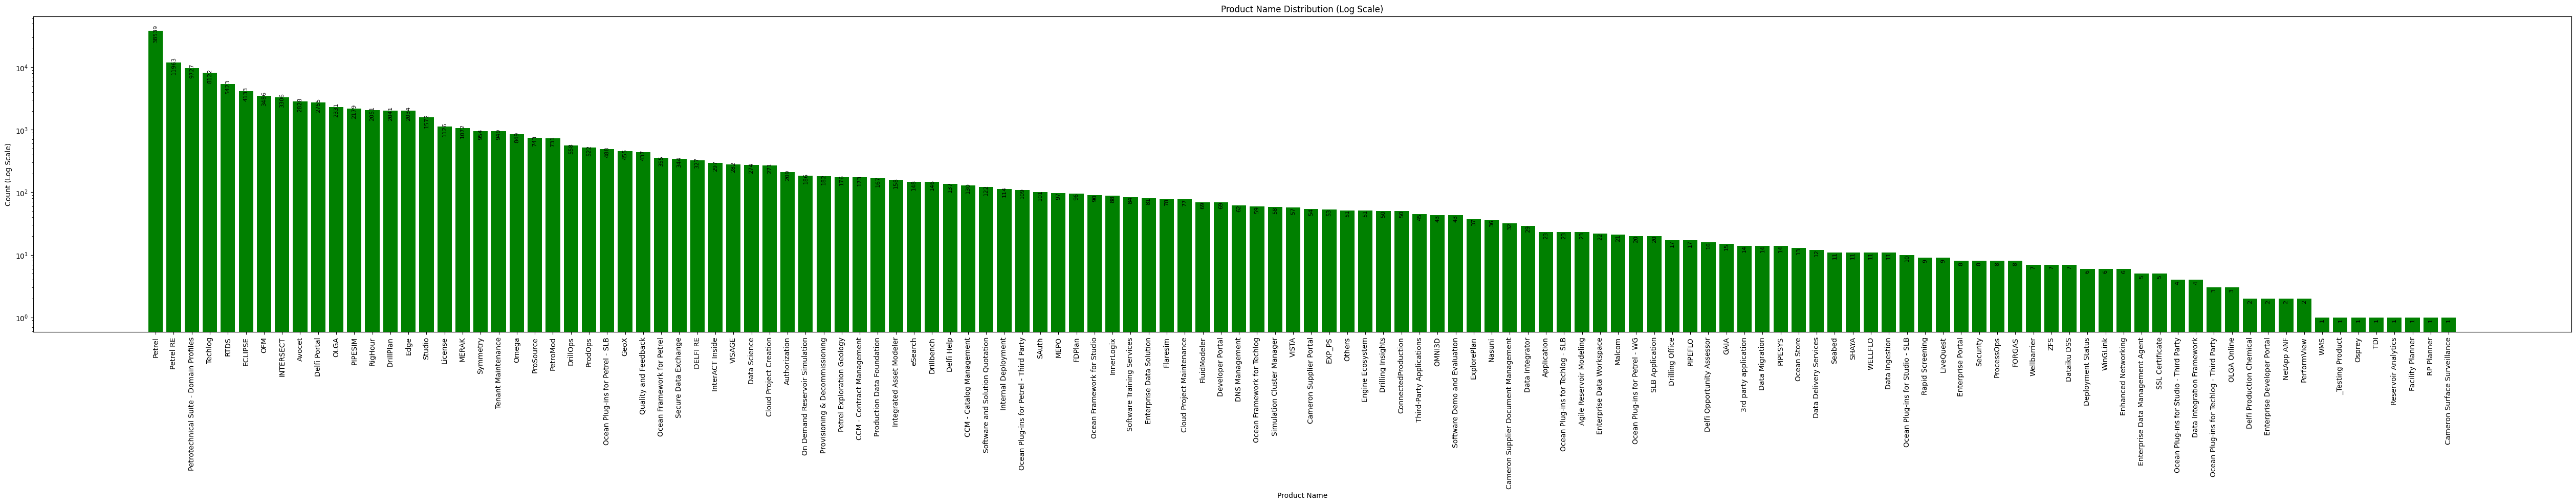

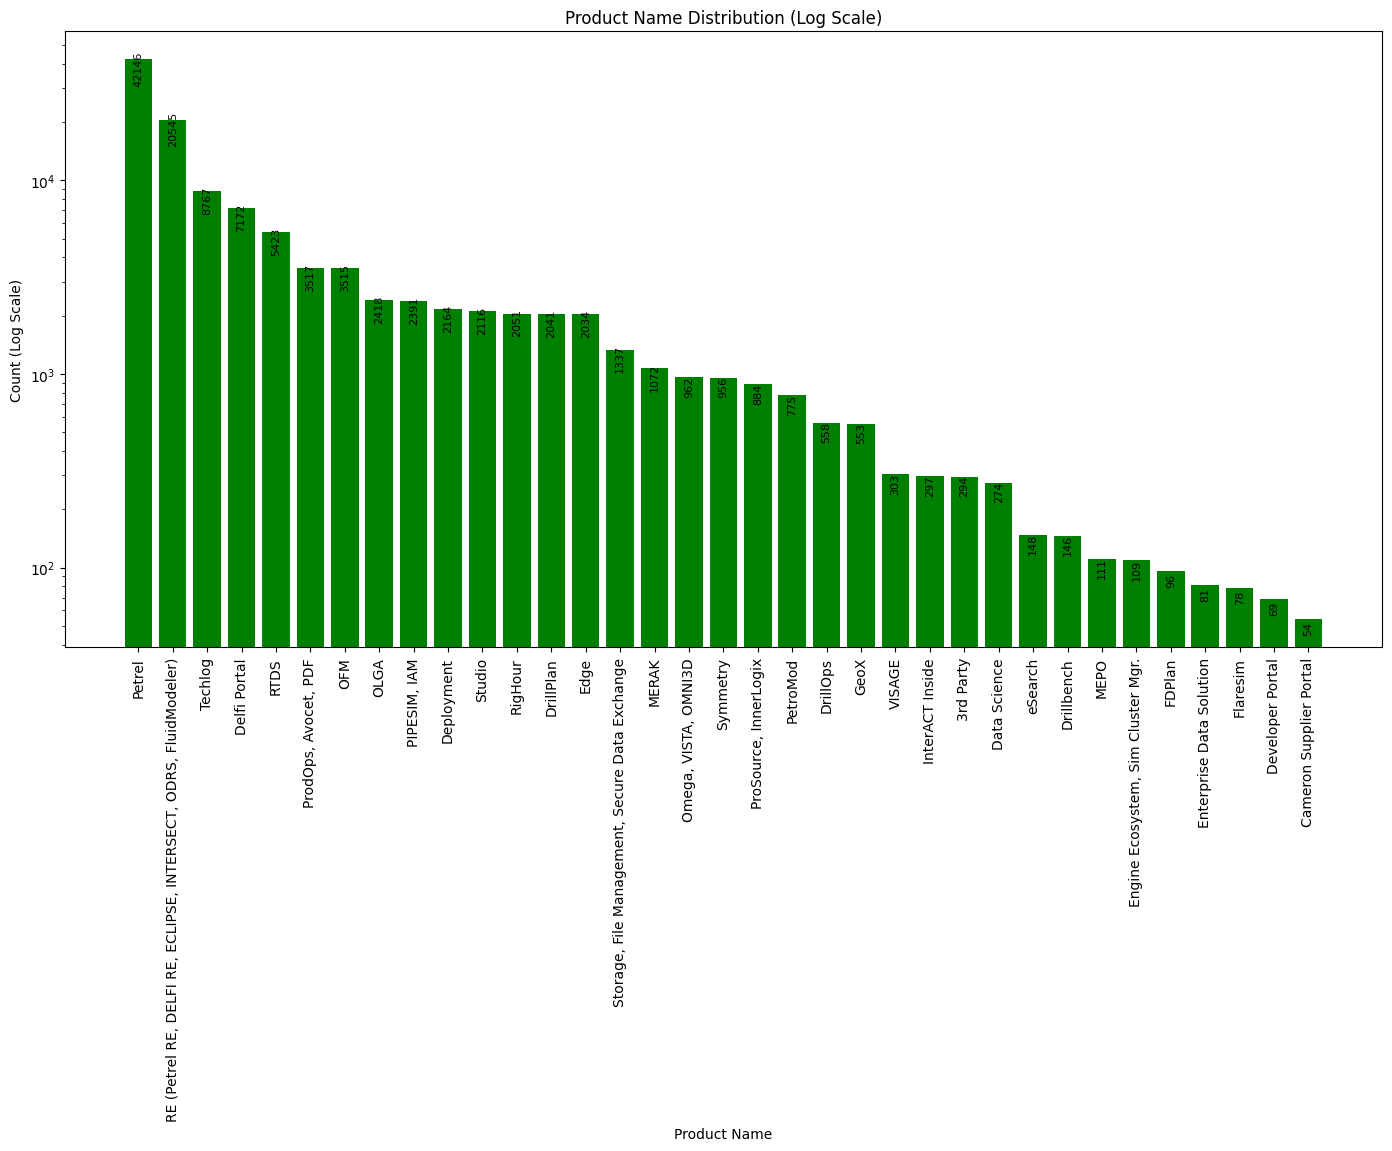

../data/processed/data_consolidated.xlsx has been saved.
../data/processed/data_train.xlsx has been saved.
../data/processed/data_test.xlsx has been saved.


In [35]:
if 'df_cleaned' not in locals():
    excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_cleaned.xlsx'
    df_cleaned = pd.read_excel(excel_file , dtype={'Request ID': str, 'Title_Cleaned': str})
print(df_cleaned.info())

df_consolidated = df_cleaned.copy()
display(df_consolidated.head(-10))

dict_category_mapping = {
    'Others': ['Other'],
    'Studio': ['Ocean Framework for Studio'],
    'Techlog': ['Ocean Framework for Techlog'],
    'PIPESIM, IAM': ['PIPESIM', 'Integrated Asset Modeler'],
    'Omega, VISTA, OMNI3D': ['Omega', 'OMEGA', 'VISTA', 'OMNI3D'],
    'ProSource, InnerLogix': ['ProSource', 'EXP_PS', 'InnerLogix'],
    'ProdOps, Avocet, PDF': ['ProdOps', 'Production Data Foundation', 'Avocet'],
    'Engine Ecosystem, Sim Cluster Mgr.': ['Engine Ecosystem', 'Simulation Cluster Manager'],
    'Petrel': ['Petrel Exploration Geology', 'Petrel Project Explorer', 'Ocean Framework for Petrel', 'Ocean Plug-ins for Petrel - SLB'],
    'Storage, File Management, Secure Data Exchange': ['Storage', 'Nasuni', 'File Management', 'Secure Data Exchange'],
    'Delfi Portal': ['Delfi Portal', 'SAuth', 'License', 'Licensing', 'Environment', 'Authorization', 'VM', 'TGX', 'Remote App'],
    'RE (Petrel RE, DELFI RE, ECLIPSE, INTERSECT, ODRS, FluidModeler)': ['Petrel RE', 'DELFI RE', 'ECLIPSE', 'INTERSECT', 'On Demand Reservoir Simulation', 'FluidModeler'],
    
    '3rd Party': ['Ocean Plug-ins for Petrel - Third party', 'Ocean Plug-ins for Petrel - Third Party',
                '3rd party application', 'Third-Party Applications', 'Ocean Plug-ins for Techlog - Third Party', 
                'App – Third Party', 'App - Third Party'],
    
    'Deployment': ['Provisioning & Decommissioning', 'Software Demo and Evaluation', 'Internal Deployment', 'Image', 
                'Deployment Status', "New PTS Deployment", 'Remove PTS Deployment', 'System Deployment', 'Deployment',
                'Cloud Project Creation', 'Cloud Project Maintenance', 'Tenant Maintenance', 'DNS Management',
                'CCM - Contract Management', 'CCM - Catalog Management', 'Software and Solution Quotation']
}
# Use Module Name to replace Product Name for all 'Petrotechnical Suite - Domain Profiles'

df_consolidated.loc[df_consolidated['Product Name'] == 'Petrotechnical Suite - Domain Profiles', 'Product Name'] = df_consolidated['Module Name']
df_consolidated.drop(columns=['Module Name'], inplace=True)
df_consolidated.dropna(subset=['Product Name'], inplace=True)

# combine the following products into corresponding categories
for category, products in dict_category_mapping.items():
    df_consolidated.loc[df_consolidated['Product Name'].isin(products), 'Product Name'] = category

#drop the rows which Product Name is 'Quality and Feedback' and 'Software Training Services'
df_consolidated = df_consolidated[df_consolidated['Product Name'] != 'Others']
df_consolidated = df_consolidated[df_consolidated['Product Name'] != 'Delfi Help']
df_consolidated = df_consolidated[df_consolidated['Product Name'] != 'Quality and Feedback']
df_consolidated = df_consolidated[df_consolidated['Product Name'] != 'Software Training Services']

#Drop the products which have less than 50 records
df_consolidated = df_consolidated.groupby('Product Name').filter(lambda x : len(x)>50)

print(df_consolidated.info())

hist_by_labels(df_cleaned, 'Product Name', log=True, horizontal=True)
hist_by_labels(df_consolidated, 'Product Name', top=None, log=True, horizontal=True)

from sklearn.model_selection import train_test_split

# Specify the file name and path
excel_file_consolidated = f'{DATA_FOLDER_PATH_PROCESSED}/data_consolidated.xlsx'
excel_file_train = f'{DATA_FOLDER_PATH_PROCESSED}/data_train.xlsx'
excel_file_test = f'{DATA_FOLDER_PATH_PROCESSED}/data_test.xlsx'

# split the data into train and test sets with 90% and 10% respectively of each product
df_train, df_test = train_test_split(df_consolidated, test_size=0.1, random_state=42, stratify=df_consolidated['Product Name'])

# Export the DataFrame to Excel
df_consolidated.to_excel(excel_file_consolidated, index=False)  # Set index to False if you don't want to export the DataFrame index
print(f'\033[94m{excel_file_consolidated}\033[0m has been saved.')
df_train.to_excel(excel_file_train, index=False)  # Set index to False if you don't want to export the DataFrame index
print(f'\033[94m{excel_file_train}\033[0m has been saved.')
df_test.to_excel(excel_file_test, index=False)  # Set index to False if you don't want to export the DataFrame index
print(f'\033[94m{excel_file_test}\033[0m has been saved.')

# Data Augmentation

In [ ]:
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_train.xlsx'

df_train = pd.read_excel(excel_file , dtype={'Request ID': str, 'Title_Cleaned': str})
print(df_train.info())
hist_by_labels(df_train, 'Product Name', top=None, log=True, horizontal=True)

In [ ]:
# function to augment a dataframe with a given product name
def augment_product_data(df, target_size=500):

    result = pd.DataFrame(columns=df.columns)
    
    df_size = len(df)
    lang_agent = ['fr', 'ja', 'ru', 'es', 'ko', 'zh', 'pt', 'ar', 'de', 'it']
    
    num_iterations = min(target_size // df_size-1, len(lang_agent))
    
    for i in range(num_iterations):
        df_temp = df.copy()
        translated_titles = df_temp["Title_Translated"].tolist()
        translated_titles = translate_array(translated_titles, src_lang='en', tar_lang=lang_agent[i],length_limit=1250)
        translated_titles = translate_array(translated_titles, src_lang=lang_agent[i], tar_lang='en',length_limit=1250)

        df_temp['Title_Translated'] = translated_titles
        result = pd.concat([result, df_temp], ignore_index=True)
    return result

TARGET_SIZE = 5000
df_augmented = pd.DataFrame(columns=df_train.columns)

# filter the products which have less than 2500 records
grouped = df_train.groupby("Product Name")
# grouped = grouped.filter(lambda x : len(x)>2500)

# Initialize tqdm to display progress bar
pbar = tqdm(total=len(grouped), desc=f"Processing")

# Create an empty list to store the processed groups
processed_groups = []

# Iterate through sub DataFrames
for product, group in grouped:
    if (len(group) > TARGET_SIZE//2):
        pbar.update(1)  # Update the progress bar
        continue
    pbar.set_description(f"Processing [{product}/{len(group)}]")
    df_product = augment_product_data(group, target_size=TARGET_SIZE)

    processed_groups.append(df_product)
    pbar.update(1)  # Update the progress bar
# Close the progress bar
pbar.close()

# Concatenate the groups back into a single DataFrame
df_additional = pd.concat(processed_groups, ignore_index=True)
df_augmented = pd.concat([df_augmented, df_additional], ignore_index=True)


In [ ]:
results = df_augmented.copy()

df_augmented = pd.concat([df_train, df_augmented], ignore_index=True)

In [ ]:
print(results.info())
df_augmented.info()

In [ ]:
df_augmented['Title_Cleaned'] = df_augmented['Title_Translated'].apply(final_clean_up)
df_augmented.dropna(subset=['Title_Cleaned'], inplace=True)
df_augmented['Length'] = df_augmented['Title_Cleaned'].apply(count_words)
df_augmented.drop_duplicates(subset=['Title_Cleaned', 'Product Name'], keep='first', inplace=True)
df_augmented.drop_duplicates(subset=['Title_Cleaned'], inplace=True)

print(df_train.info())
print(df_augmented.info())

hist_by_labels(df_train, 'Product Name', top=None, log=True, horizontal=True)
hist_by_labels(df_augmented, 'Product Name', top=None, log=True, horizontal=True)

In [ ]:

# Specify the file name and path
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_augmented.xlsx'

# Export the DataFrame to Excel
df_augmented.to_excel(excel_file, index=False)  # Set index to False if you don't want to export the DataFrame index